# Set up the scenario

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn
import sklearn.calibration
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(3923)

## Generate candidates

There are only two features: `num_reviews` and `avg_rating`. Each search has an identifier, `search_id`

In [ ]:
def generate_searches(num_searches=1000, items_per_search=10):
  results = None

  total_rows = num_searches * items_per_search

  results = pd.DataFrame({
      "num_reviews": np.random.randint(low=1, high=100, size=total_rows),
      "avg_rating": np.random.normal(loc=3, scale=1, size=total_rows),
  })

  results["search_id"] = [int(index / items_per_search) for index in list(results.index)]

  return results

searches = generate_searches(num_searches=10000, items_per_search=30)

None

## Apply a ranking

Here choosing `num_reviews` as the sole feature to sort the rankings by.

In [ ]:
def generate_ranking(searches, sorted_feature, ascending=False):
  output = searches.copy()

  # Use "first" to break ties arbitrarily
  output["position"] = output.groupby("search_id")[sorted_feature].rank(
      "first", ascending=ascending).astype(int)

  return output

with_ranking = generate_ranking(searches, "num_reviews")
with_ranking.sort_values(by=["search_id", "position"]).head(10)

,num_reviews,avg_rating,search_id,position
6,99,2.113985,0,1
17,94,3.274957,0,2
13,93,2.794540,0,3
7,91,2.328554,0,4
8,85,3.854156,0,5
27,82,3.960140,0,6
3,77,4.804854,0,7
14,76,3.236912,0,8
22,75,4.660930,0,9
20,68,0.927447,0,10


## Apply customer behavior

I specify a basic behavior model where users care about two factors: `position` and `avg_rating`. Here I use inverse position as a convenient function to represent diminishing preference for position.

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def create_inverse(df, column, inplace=False):
  if inplace:
    output = df
  else:
    output = df.copy()

  output[f"inverse_{column}"] = 1 / output[column]

  return output

def apply_customer_probability(searches, coefficients, features, inplace=False):
  if len(features) != len(coefficients) - 1:
    raise ValueError("Expecting one more coefficient than features")

  if inplace:
    output = searches
  else:
    output = searches.copy()

  logit = 0
  for index, feature in enumerate(features):
    logit += searches[features[index]] * coefficients[index + 1]
  logit += coefficients[0]

  output["probability"] = sigmoid(logit)
  
  return output

with_inverse = create_inverse(with_ranking, "position", inplace=True)
with_probability = apply_customer_probability(
    with_inverse, [-3, 5, 0.1], ["inverse_position", "avg_rating"])

with_probability.sort_values(by=["search_id", "position"]).head(10)

,num_reviews,avg_rating,search_id,position,inverse_position,probability
6,99,2.113985,0,1,1.000000,0.901268
17,94,3.274957,0,2,0.500000,0.456981
13,93,2.794540,0,3,0.333333,0.258481
7,91,2.328554,0,4,0.250000,0.179882
8,85,3.854156,0,5,0.200000,0.165953
27,82,3.960140,0,6,0.166667,0.145461
3,77,4.804854,0,7,0.142857,0.141216
14,76,3.236912,0,8,0.125000,0.113920
22,75,4.660930,0,9,0.111111,0.121495
20,68,0.927447,0,10,0.100000,0.082621


## Generate labels

Generate binary labels randomly, using the output from the probability model specified earlier.

In [ ]:
def apply_labels(searches, label, inplace=False):
  if inplace:
    output = searches
  else:
    output = searches.copy()

  random_numbers = np.random.uniform(size=len(searches))
  output[label] = random_numbers <= output["probability"]

  return output

label = "had_click"

with_labels = apply_labels(with_probability, label, inplace=True)

with_labels.sort_values(by=["search_id", "position"]).head(10)

,num_reviews,avg_rating,search_id,position,inverse_position,probability,had_click
6,99,2.113985,0,1,1.000000,0.901268,True
17,94,3.274957,0,2,0.500000,0.456981,True
13,93,2.794540,0,3,0.333333,0.258481,False
7,91,2.328554,0,4,0.250000,0.179882,False
8,85,3.854156,0,5,0.200000,0.165953,False
27,82,3.960140,0,6,0.166667,0.145461,False
3,77,4.804854,0,7,0.142857,0.141216,False
14,76,3.236912,0,8,0.125000,0.113920,False
22,75,4.660930,0,9,0.111111,0.121495,False
20,68,0.927447,0,10,0.100000,0.082621,True


`inverse_position` has a strong positive correlation with `had_click`, which we should expect since position is important.

`num_reviews` has a similarly strong correlation with `had_click`, because `num_reviews` is how we rank. Even though users in our behavior model don't actually care about `num_reviews`, they care about rank and the correlation between rank and `num_reviews` leads to a correlation between the label and `num_reviews`.

In [ ]:
features_with_position = ["inverse_position", "avg_rating", "num_reviews"]

with_labels[[label] + features_with_position].corr(method="spearman")

,had_click,inverse_position,avg_rating,num_reviews
had_click,1.000000,0.257624,0.025949,0.249675
inverse_position,0.257624,1.000000,-0.000406,0.967182
avg_rating,0.025949,-0.000406,1.000000,-0.000904
num_reviews,0.249675,0.967182,-0.000904,1.000000


# Models

## Model without position

Here we use `avg_rating` and `num_reviews` as our two features. Note that both have a positive coefficient, with `num_reviews` having a relatively larger coefficient (relative to its scale) that is much more significant.

The coefficient for `avg_rating` (~0.08) is below the true value of its causal impact on the label (0.1).

In [ ]:
features_without_position = ["avg_rating", "num_reviews"]

logistic_without_position = sm.Logit(
    with_labels[label],
    sm.add_constant(with_labels[features_without_position].astype(float),
                    has_constant='add')
    ).fit()

logistic_without_position.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.368920
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              had_click   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299997
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                 0.08230
Time:                        19:39:08   Log-Likelihood:            -1.1068e+05
converged:                       True   LL-Null:                   -1.2060e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.7064      0.023   -162.992      0.000      -3.751      -3.662
avg_rating      0.0838      0.005     15.253      0.000       0.073       0.095
num_reviews     0.0280      0.000    129.728      0.000       0.028       0.028
===============================================================================
"""

## Test against a different ranker

Let's create a new sample with a very different ranker. An exactly opposite ranker, in fact, that ranks *ascendingly* by `num_reviews`. Users have unchanged behavior where they still care exclusively about position and `avg_rating`.

In [ ]:
test_searches = generate_searches(num_searches=10000, items_per_search=30)
test_with_ranking = generate_ranking(test_searches, "num_reviews", ascending=True)
test_with_inverse = create_inverse(test_with_ranking, "position", inplace=True)
test_with_probability = apply_customer_probability(
    test_with_inverse, [-3, 5, 0.1], ["inverse_position", "avg_rating"])
test_with_labels = apply_labels(test_with_probability, label, inplace=True)

test_with_labels.sort_values(by=["search_id", "position"]).head(10)

,num_reviews,avg_rating,search_id,position,inverse_position,probability,had_click
21,3,2.999291,0,1,1.000000,0.908871,True
6,5,4.289860,0,2,0.500000,0.482254,True
24,6,3.237804,0,3,0.333333,0.267067,False
2,7,4.608433,0,4,0.250000,0.215996,False
25,16,4.944281,0,5,0.200000,0.181596,False
1,18,2.468763,0,6,0.166667,0.127885,True
28,19,4.206485,0,7,0.142857,0.134114,False
7,21,3.450691,0,8,0.125000,0.116096,False
13,22,2.380028,0,9,0.111111,0.099174,False
4,25,1.229602,0,10,0.100000,0.084940,False


### Evaluation

I'm going to set aside proper ranking metrics for now, and use well-known and intuitive metrics that still demonstrate the obvious problems.

Correlation between label and prediction is now negative. That's not good.

In [ ]:
predictions_without_position = logistic_without_position.predict(
    sm.add_constant(test_with_labels[features_without_position].astype(float), has_constant='add'))

test_with_labels["pred_without_position"] = predictions_without_position

test_with_labels[[label, "pred_without_position"]].corr(method="spearman")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,had_click,pred_without_position
had_click,1.000000,-0.245803
pred_without_position,-0.245803,1.000000


We can see this in the calibration plot, where predictions are very miscalibrated.

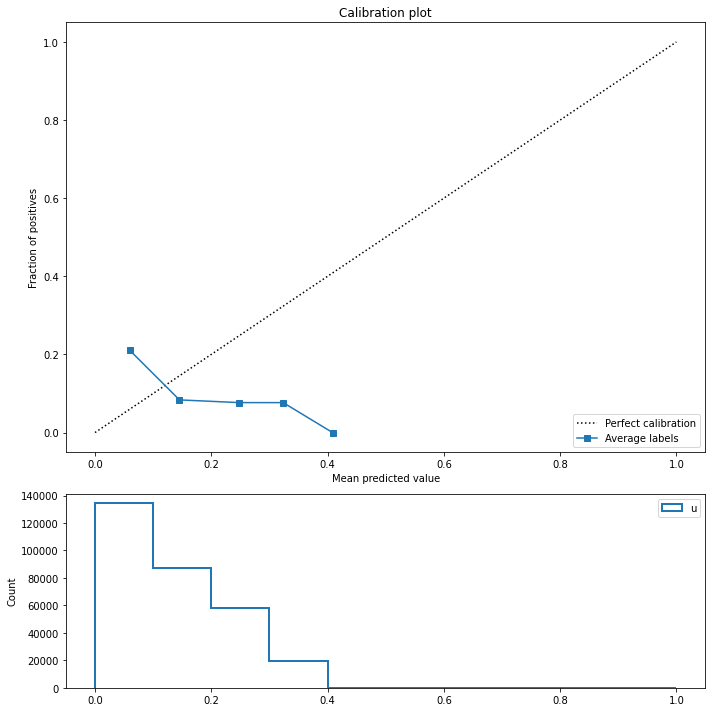

In [ ]:
def plot_calibration_curve(labels, predictions, n_bins=10):
  if len(labels) != len(predictions):
    raise ValueError("Need matching lengths between labels and predictions")

  fraction_of_positives, mean_predicted_value = sklearn.calibration.calibration_curve(
      labels, predictions, n_bins=n_bins
  )

  fig_index = "calibration"

  fig = plt.figure(fig_index, figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfect calibration")

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Average labels")

  ax2.hist(predictions, range=(0, 1), bins=n_bins, label="predictions", histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title("Calibration plot")

  ax1.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend("uppder right", ncol=2)

  plt.tight_layout()
  plt.show()

  return fig
  
plot_calibration_curve(test_with_labels[label], predictions_without_position)

None

If we plot actuals and predictions by position, we can see how clicks diminish with position, just as before, but that predictions actually increase with position. This happens for an obvious reason: the model believes that higher `num_reviews` leads to more clicks, when now `num_reviews` by leads to a lower rank, and, through position bias, lower clicks. `num_reviews` was used by the model as a proxy for the position effect.

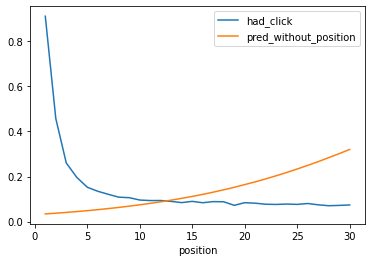

In [ ]:
test_with_labels.groupby('position')[[label, "pred_without_position"]].mean().plot()

None

## Model with position

Now we use position as a feature in our model. Since the behavior model follows a logistic specification, the logistic model is able to identify nearly the exact coefficients. It learns that `inverse_position` matters, `avg_rating` matters somewhat, and `num_reviews` does not matter at all.

In [ ]:
logistic_with_position = sm.Logit(
    with_labels[label],
    sm.add_constant(with_labels[features_with_position].astype(float),
                    has_constant='add')
    ).fit()

logistic_with_position.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.328596
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              had_click   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299996
Method:                           MLE   Df Model:                            3
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1826
Time:                        19:39:16   Log-Likelihood:                -98579.
converged:                       True   LL-Null:                   -1.2060e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.9984      0.023   -129.665      0.000      -3.044      -2.953
inverse_position     5.0243      0.041    123.682      0.000       4.945       5.104
avg_rating           0.1022      0.006     17.027      0.000       0.090       0.114
num_reviews         -0.0003      0.000     -1.063      0.288      -0.001       0.000
====================================================================================
"""

### Evaluation on the test sample

Even with the ranking algorithm reversed, this model does perfectly fine. Its scores have a strong positive correlation with the label, it is perfectly calibrated, and it is accurate for every position.

In [ ]:
predictions_with_position = logistic_with_position.predict(
    sm.add_constant(test_with_labels[features_with_position].astype(float), has_constant='add'))

test_with_labels["pred_with_position"] = predictions_with_position

test_with_labels[[label, "pred_with_position"]].corr(method="spearman")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,had_click,pred_with_position
had_click,1.000000,0.265055
pred_with_position,0.265055,1.000000


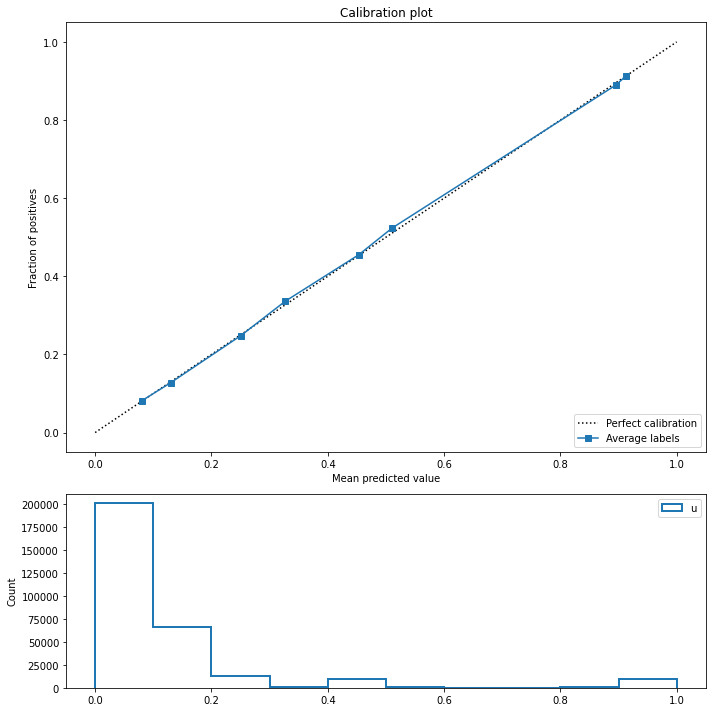

In [ ]:
plot_calibration_curve(test_with_labels[label], predictions_with_position)

None

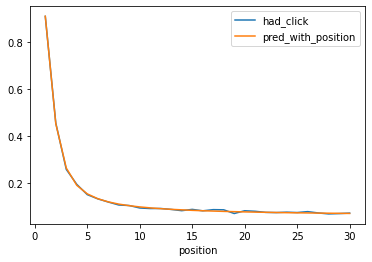

In [ ]:
test_with_labels.groupby('position')[[label, "pred_with_position"]].mean().plot()

None

# A multiplicative behavior model

The logistic model did fine with user behavior that matches its specification. Let's now create a very different specification, where click will be defined by position bias times a logistic probability.

Position bias is scaled such that the first position has a bias of 1, and the logistic probability is the probability of click at that first position.

In [ ]:
def apply_multiplicative_probability(searches, position_weights, coefficients, features,
                                     inplace=False):
  if len(features) != len(coefficients) - 1:
    raise ValueError("Expecting one more coefficient than features")

  if inplace:
    output = searches
  else:
    output = searches.copy()

  logit = 0
  for index, feature in enumerate(features):
    logit += searches[features[index]] * coefficients[index + 1]
  logit += coefficients[0]

  output["base_probability"] = sigmoid(logit)
  output["probability"] = output["base_probability"] * position_weights
  
  return output

# For position bias, I will still use inverse position. This is a realistic curve,
# and gives a bias of 1.0 at the first position.
position_bias = with_inverse["inverse_position"]

# Slightly different coefficients to give this a reasonable scale and range
coefficients_for_mult_example = [-2, 0.5]

with_mult_probability = apply_multiplicative_probability(
    with_inverse, position_bias, coefficients_for_mult_example, ["avg_rating"])

with_mult_labels = apply_labels(with_mult_probability, label, inplace=True)

with_mult_labels.sort_values(by=["search_id", "position"]).head(10)

,num_reviews,avg_rating,search_id,position,inverse_position,base_probability,probability,had_click
6,99,2.113985,0,1,1.000000,0.280293,0.280293,False
17,94,3.274957,0,2,0.500000,0.410349,0.205175,False
13,93,2.794540,0,3,0.333333,0.353719,0.117906,False
7,91,2.328554,0,4,0.250000,0.302436,0.075609,False
8,85,3.854156,0,5,0.200000,0.481778,0.096356,True
27,82,3.960140,0,6,0.166667,0.495018,0.082503,False
3,77,4.804854,0,7,0.142857,0.599271,0.085610,True
14,76,3.236912,0,8,0.125000,0.405755,0.050719,False
22,75,4.660930,0,9,0.111111,0.581873,0.064653,False
20,68,0.927447,0,10,0.100000,0.177077,0.017708,False


## Logistic model with position

Now the model with position still generates coefficients, and still knows that `inverse_position` is the dominant factor, but it can't fit the behavior model due to its functional form. It now finds a large (and signficant) positive coefficient for `num_reviews`.

In [ ]:
logistic_with_position_mult = sm.Logit(
    with_mult_labels[label],
    sm.add_constant(with_mult_labels[features_with_position].astype(float),
                    has_constant='add')
    ).fit()

logistic_with_position_mult.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.168980
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              had_click   No. Observations:               300000
Model:                          Logit   Df Residuals:                   299996
Method:                           MLE   Df Model:                            3
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1687
Time:                        19:39:23   Log-Likelihood:                -50694.
converged:                       True   LL-Null:                       -60983.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.8166      0.041   -140.426      0.000      -5.898      -5.735
inverse_position     2.4278      0.035     70.272      0.000       2.360       2.495
avg_rating           0.3600      0.009     40.319      0.000       0.343       0.378
num_reviews          0.0198      0.000     42.869      0.000       0.019       0.021
====================================================================================
"""

### Evaluation

Now our test sample predictions have weak correlation with the label, because the test sample has the different ranking function, and in particular, `num_reviews` is not positively correlated with rank in the test sample.

In [ ]:
test_position_bias = test_with_inverse["inverse_position"]

test_with_mult_probability = apply_multiplicative_probability(
    test_with_inverse, test_position_bias, coefficients_for_mult_example, ["avg_rating"])
test_with_mult_labels = apply_labels(test_with_mult_probability, label, inplace=True)

predictions_with_position = logistic_with_position_mult.predict(
    sm.add_constant(test_with_mult_labels[features_with_position].astype(float),
                    has_constant='add'))

test_with_mult_labels["pred_with_position"] = predictions_with_position

test_with_mult_labels[[label, "pred_with_position"]].corr(method="spearman")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,had_click,pred_with_position
had_click,1.00000,0.06726
pred_with_position,0.06726,1.00000


Calibration is awful.

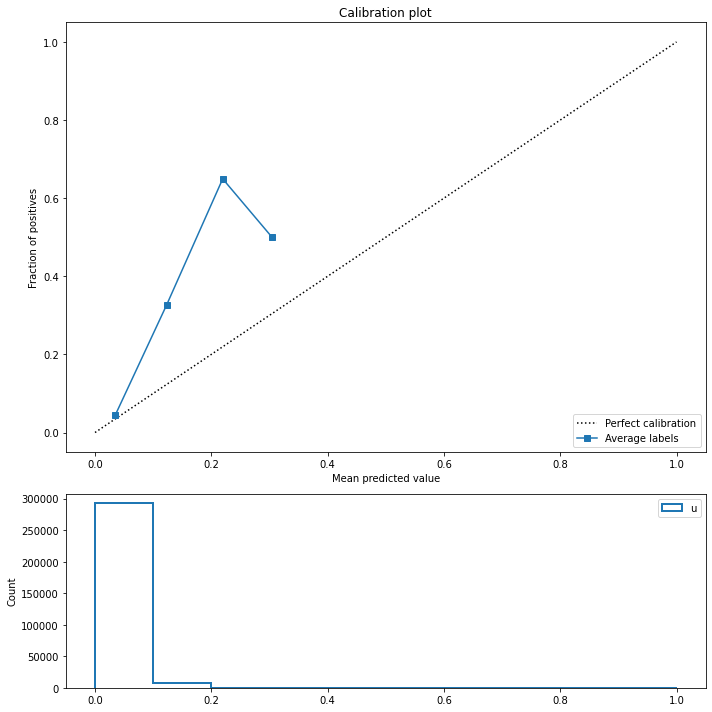

In [ ]:
plot_calibration_curve(test_with_mult_labels[label], test_with_mult_labels["pred_with_position"])

None

Now predictions decrease over the first few positions, and then increase afterwards (despite actual clicks continuing to decrease with position).

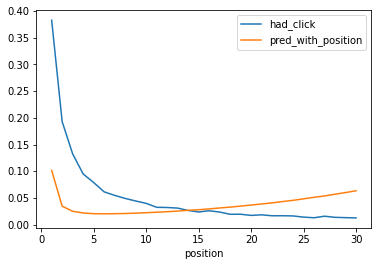

In [ ]:
test_with_mult_labels.groupby('position')[[label, "pred_with_position"]].mean().plot()

## GBDT model

Using a logistic model might be unfair, because it has very little expressiveness for complex relationships. However, if we use a somewhat more expressive model (a basic gradient boosted decision tree) we can still see the same effect.

Multiplicative behavior is hard to fit correctly. Fitting the training data is not the same as finding the true behavior model.

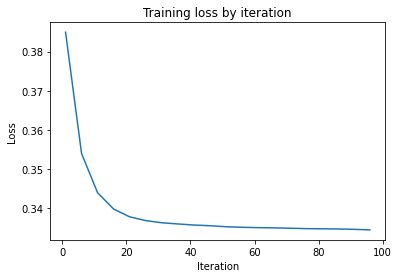

In [ ]:
X = with_mult_labels[features_with_position]
y = with_mult_labels[label]

num_estimators = 100

clf = GradientBoostingClassifier(n_estimators=num_estimators, learning_rate=0.1, 
                                 max_depth=3, random_state=0).fit(X, y)

test_deviance = np.zeros((num_estimators,), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X)):
    test_deviance[i] = clf.loss_(y, y_pred)

plt.plot(
    (np.arange(test_deviance.shape[0]) + 1)[::5],
    test_deviance[::5],
    "-",
    label=label,
)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss by iteration")

None

This model at least learns to put less weight on `num_reviews` than `avg_rating`. We likely are getting closer to a correct model.

In [ ]:
list(zip(features_with_position, clf.feature_importances_))

[('inverse_position', 0.8726239623331307),
 ('avg_rating', 0.12003462879018513),
 ('num_reviews', 0.007341408876684321)]

On the test sample our predictions still have poor calibration.

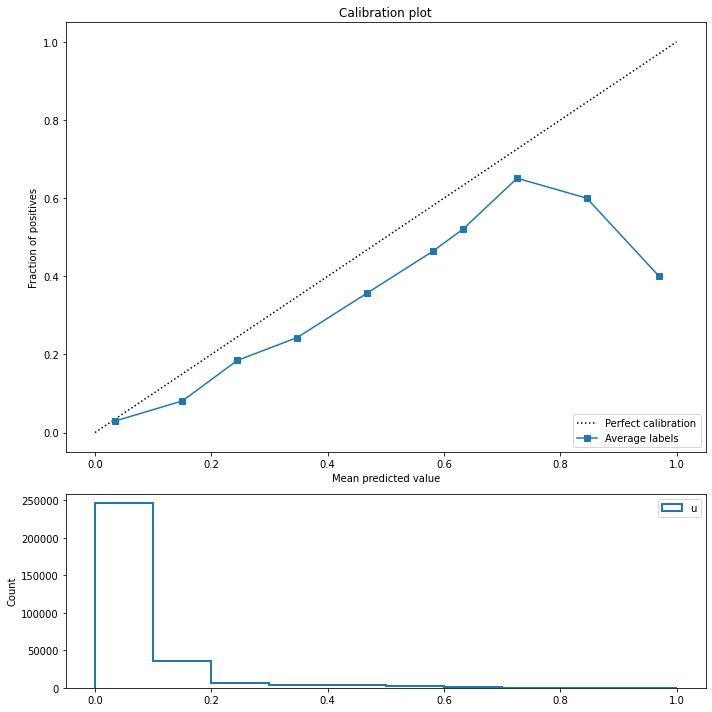

In [ ]:
X_test = test_with_mult_labels[features_with_position]
y_test = test_with_mult_labels[label]

preds_gbdt = [pred[1] for pred in clf.predict_proba(X_test)]

test_with_mult_labels["pred_gbdt"] = preds_gbdt

plot_calibration_curve(test_with_mult_labels[label], test_with_mult_labels["pred_gbdt"])

None

Predictions now diminish monotonically with respect to position, but more dramatically than actual clicks.

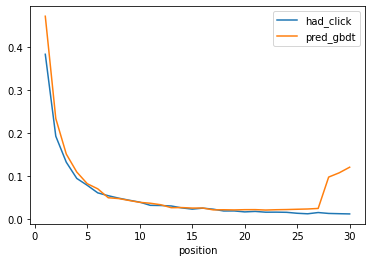

In [ ]:
test_with_mult_labels.groupby('position')[[label, "pred_gbdt"]].mean().plot()

None

It's promising that the GBDT does a lot better than the logistic model. I purposely kept the model fairly underspecified. Perhaps a larger and more expressive model could do better yet.

# Conclusion

Ultimately, functional form matters a lot. If we have the right functional form then we can attribute an approrpriate effect to position even without a complex model, letting us correctly estimate counterfactuals with different ranking algorithms. However if we have an incorrectly identified model, accurate performance on the training sample won't generalize to other rankers. Which is a problem if we want to change our ranking.